<center>
<h1><b>Lab 6</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>October 8, 2020</b></h3>
<hr>
</center>

#### Imports

In [258]:
from scipy.integrate import solve_ivp
from functools import partial
from numpy import apply_along_axis as thread
from numpy import cross, hsplit, vsplit, hstack, asarray, sin, cos, set_printoptions, pi, linspace
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

#### Customization

In [230]:
set_printoptions(sign=' ', linewidth=100, precision=4, suppress=True)
plt.style.use('dark_background')

In [231]:
saturn_pos = asarray([ 0.000000000000000E-00,  0.000000000000000E-00,  0.000000000000000E-00])
saturn_vel = asarray([ 0.000000000000000E-00,  0.000000000000000E-00,  0.000000000000000E-00])
saturn_m = 1.0
titan_pos = asarray([-2.349442311566901E-03,  7.153850305740229E-03, -3.453819029042604E-03])
titan_vel = asarray([-3.051170257091698E-03, -6.116575942904424E-04,  6.191676545191825E-04])
titan_m = 2.367e-4
rhea_pos = asarray([-1.255393996976257E-03,  2.964327117947999E-03, -1.436487271404112E-03])
rhea_vel = asarray([-4.561058618370766E-03, -1.378619573613746E-03,  1.133396533665187E-03])
rhea_m = 4.062e-6
hyperion_pos = asarray([ 3.643573903413987E-03, -7.406358781088398E-03,  3.362810684983125E-03])
hyperion_vel = asarray([ 2.818505976172301E-03,  1.278934691098328E-03, -9.114757023594637E-04])
hyperion_m = 9.754e-9
hyperion_r = (9.024e-7, 1.0468e-6, 6.8651e-7)
hyperion_T = 21.28

In [232]:
def rhs(t, y, mu, k, L, G):
    m1, m2, m3, m4 = mu
    x1, x2, x3, x4, v1, v2, v3, v4 = hsplit(y, 8)
    return hstack((
        v1, v2, v3, v4,
        -G*(m2*(x1-x2)/norm(x1-x2)**3+m3*(x1-x3)/norm(x1-x3)**3+m4*(x1-x4)/norm(x1-x4)**3),
        -G*(m1*(x2-x1)/norm(x2-x1)**3+m3*(x2-x3)/norm(x2-x3)**3+m4*(x2-x4)/norm(x2-x4)**3),
        -G*(m1*(x3-x1)/norm(x3-x1)**3+m2*(x3-x2)/norm(x3-x2)**3+m4*(x3-x4)/norm(x3-x4)**3)+k*(norm(x4-x3)-L)**2*(x4-x3)/norm(x4-x3),
        -G*(m1*(x4-x1)/norm(x4-x1)**3+m2*(x4-x2)/norm(x4-x2)**3+m3*(x4-x3)/norm(x4-x3)**3)+k*(norm(x3-x4)-L)**2*(x3-x4)/norm(x3-x4)
    ))

In [233]:
def COM(x2, x3, alpha):
    return (x2 + (alpha ** (-1) - 1) * x3) / (1 + (alpha ** (-1) - 1))

In [234]:
def cart2sph(x, y, z):
    return np.sqrt(z**2+y**2+z**2), np.arctan2(y, x), np.arctan2(np.sqrt(x**2+y**2), z)

In [235]:
def run_simulation(theta, dtheta, phi, dphi, fps, duration, k, G, alpha=0.5, vel_boost=1.0):
    hyperion_a_pos=hyperion_pos+max(hyperion_r)*asarray([sin(phi)*cos(theta),sin(phi)*sin(theta),cos(phi)])
    hyperion_a_vel=vel_boost*hyperion_vel+max(hyperion_r)*asarray([dphi*cos(phi)*cos(theta)-dtheta*sin(phi)*sin(theta),dphi*cos(phi)*sin(theta)+dtheta*sin(phi)*cos(theta),-dphi*sin(phi)])
    hyperion_a_m=alpha*hyperion_m
    hyperion_b_pos=hyperion_pos-max(hyperion_r)*asarray([sin(phi)*cos(theta),sin(phi)*sin(theta),cos(phi)])
    hyperion_b_vel=vel_boost*hyperion_vel-max(hyperion_r)*asarray([dphi*cos(phi)*cos(theta)-dtheta*sin(phi)*sin(theta),dphi*cos(phi)*sin(theta)+dtheta*sin(phi)*cos(theta),-dphi*sin(phi)])
    hyperion_b_m=(1-alpha)*hyperion_m

    mu = saturn_m, titan_m, hyperion_a_m, hyperion_b_m
    t_eval = linspace(0.0, duration, num=int(fps*duration))
    L = 2.0 * max(hyperion_r)
    df = partial(rhs, k=k, L=L, mu=mu, G=G)
    state0 = hstack((
        saturn_pos, titan_pos, hyperion_a_pos, hyperion_b_pos,
        saturn_vel, titan_vel, hyperion_a_vel, hyperion_b_vel
    ))
    sol = solve_ivp(df, [0.0, duration], state0, t_eval=t_eval, rtol=1.0e-6, atol=1.0e-6)
    if not sol.success:
        print(sol.message)
        raise RuntimeError
    return *vsplit(sol.y, 8), sol.t

## Problem 1

Use the provided starter program `lab6-hyperion.py` (or your own equivalent program) to study the motion of Hyperion, one of Saturn’s moons, in the dumbbell model discussed in class. 

- First, observe and display the orbital motion and the motion of the dumbbell axis. 
- In particular, try different initial conditions for the Hyperion center of mass location and velocity, and the dumbbell axis orientation and angular velocity. 
- Study both the case of a hypothetical circular orbit as well as a few (2-3) elliptic orbits with different eccentricities. 
- Make sure to include the real orbit of Hyperion with perihelion $a(1-e)\approx1$, $3\times10^6$ km$=1$ HU (“Hyperion unit”), and eccentricity $e = 0.123$. 
- How would you characterize the nature of the spinning motion of Hyperion, based on your simulations?  
- Does the kind of spinning motion depend on the type of orbit, and if yes, how?

In [236]:
theta, dtheta = pi, pi / hyperion_T
phi, dphi = pi, pi / hyperion_T

In [237]:
duration = 22.0
fps = 24.0
G = 8.458e-8
k = 1.4e3
global_fig_size = (16,16)
alpha = 0.5

In [238]:
    x0, x1, x2, x3, v0, v1, v2, v3, t = run_simulation(theta, dtheta, phi, dphi, fps, duration, k, G)

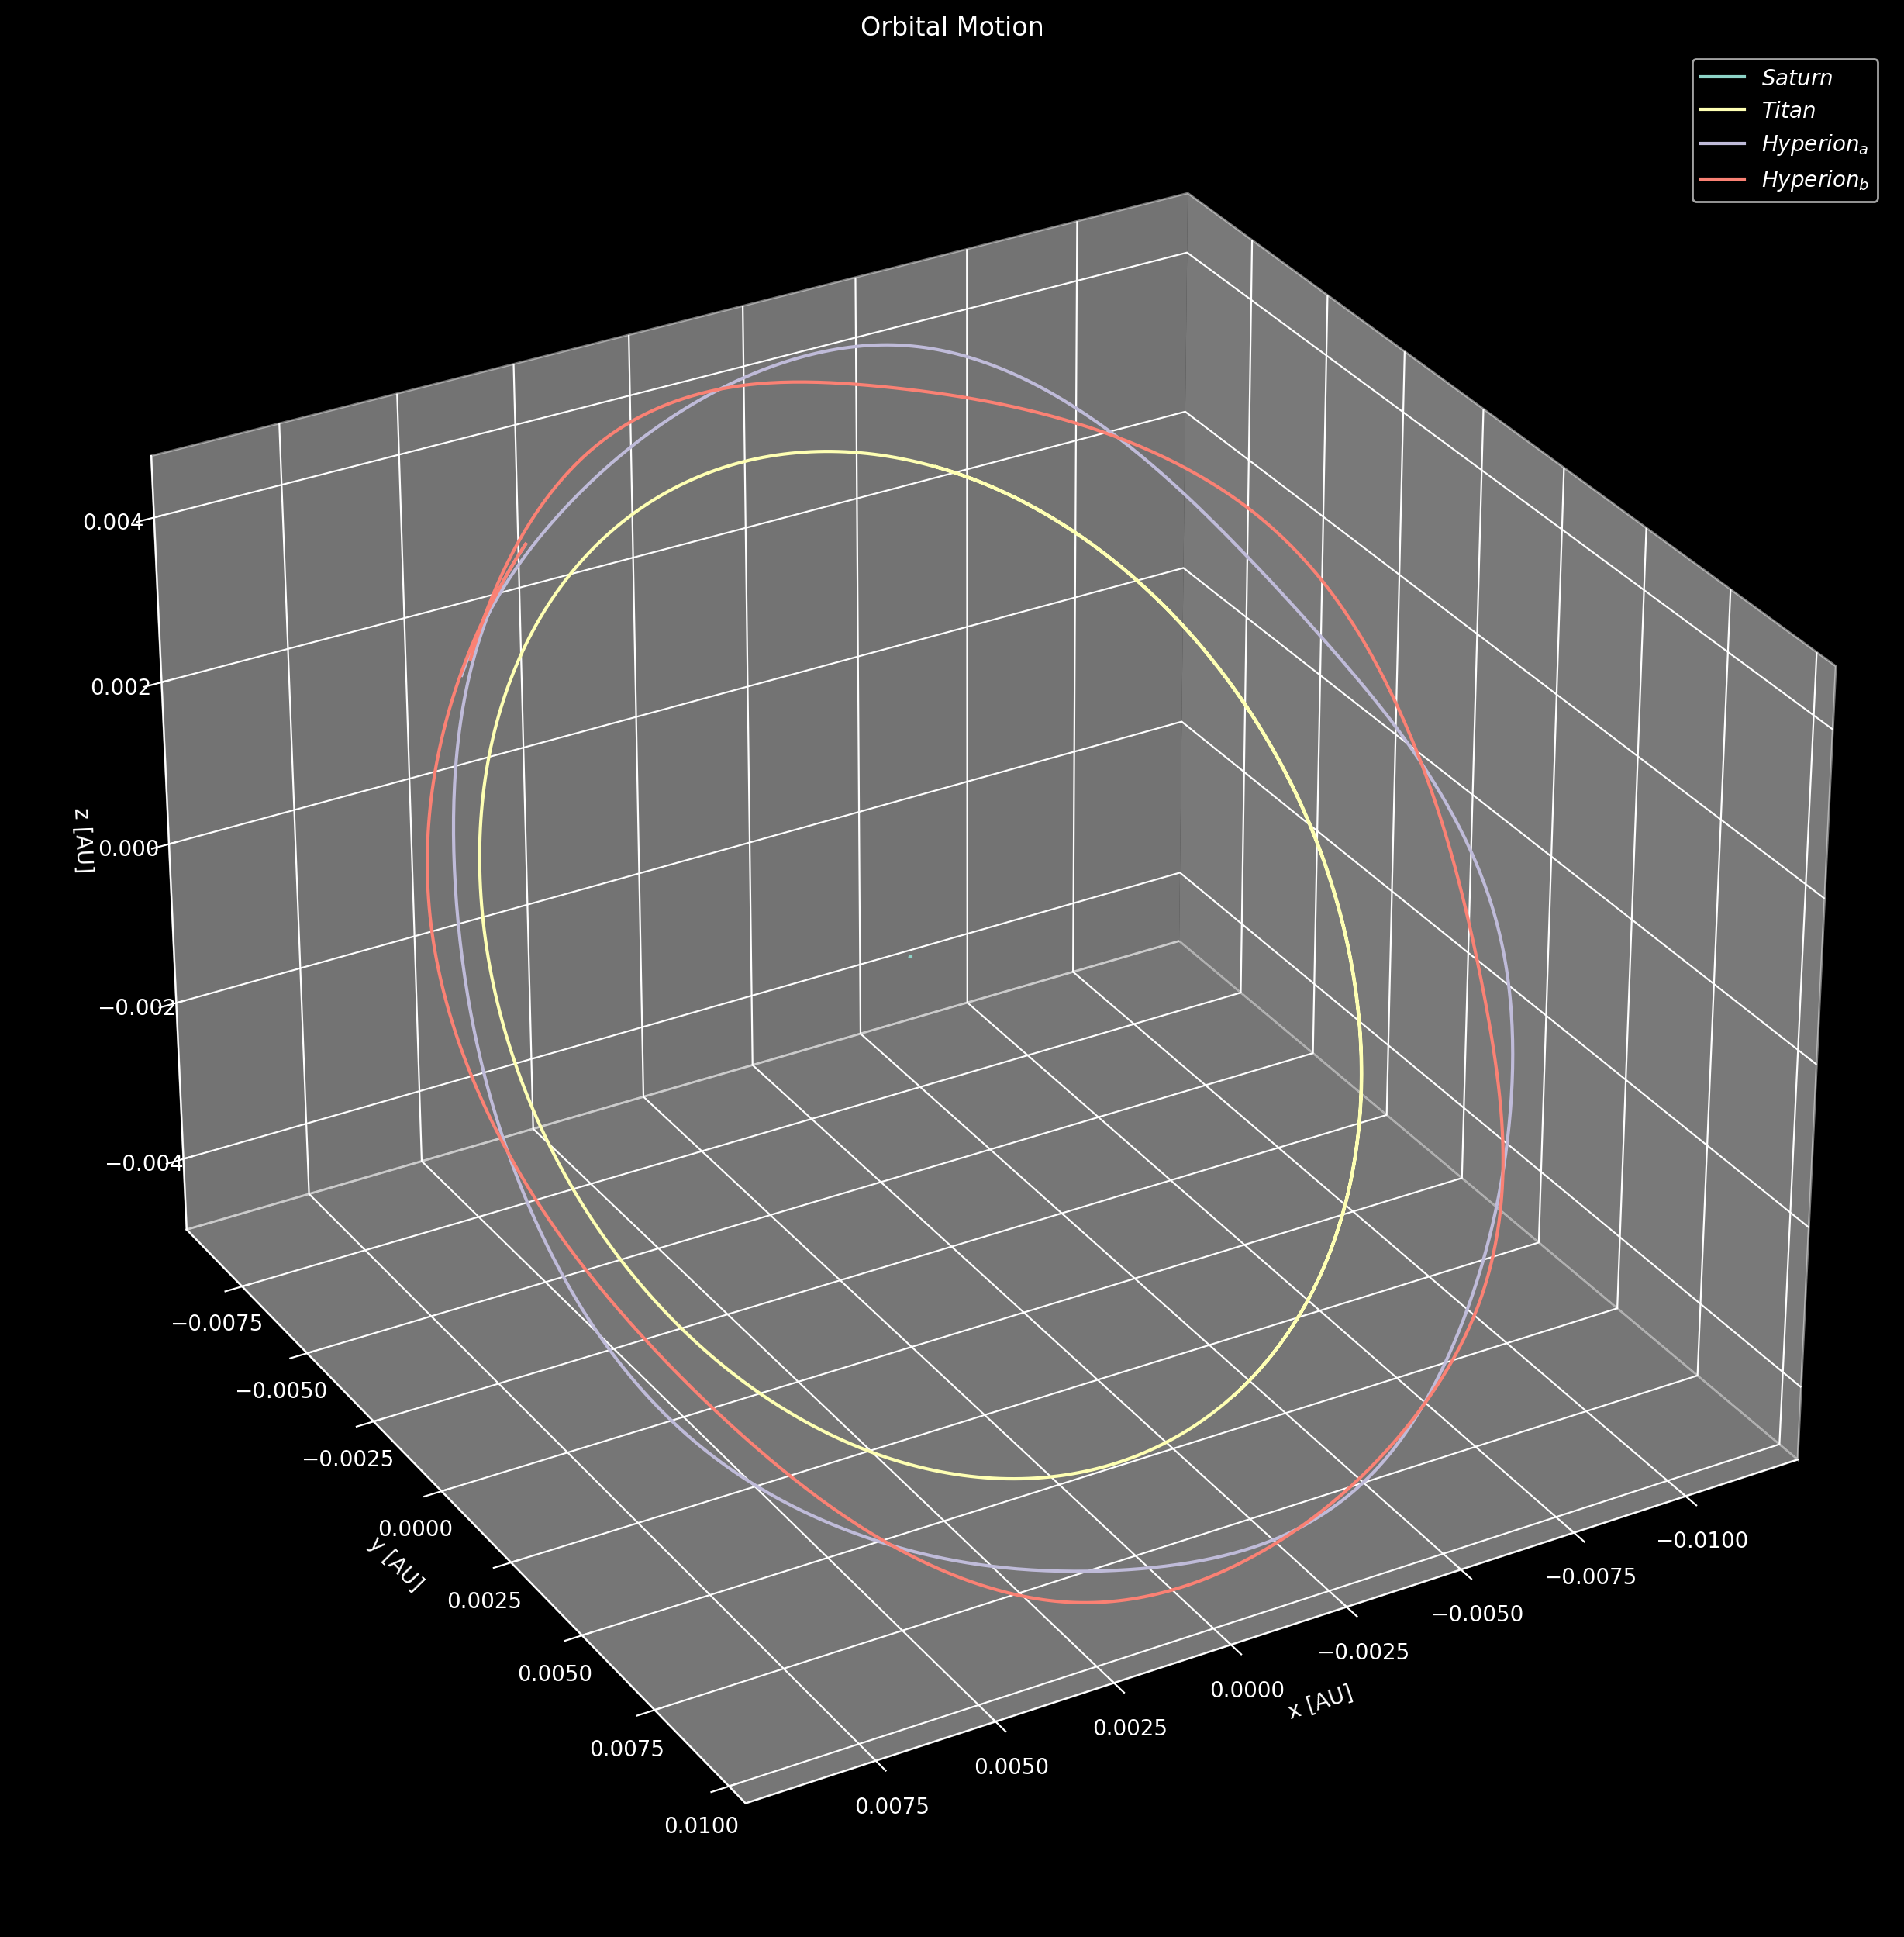

In [239]:
fig = plt.figure(figsize=global_fig_size, dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Orbital Motion')
ax.plot(x0[0,:], x0[1,:], x0[2,:], label=r'$Saturn$')
ax.plot(x1[0,:], x1[1,:], x1[2,:], label=r'$Titan$')
ax.plot(x2[0,:], x2[1,:], x2[2,:], label=r'$Hyperion_a$')
ax.plot(x3[0,:], x3[1,:], x3[2,:], label=r'$Hyperion_b$')
ax.view_init(30, 60)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
plt.legend()
plt.savefig('pictures/P1a.png')

In [240]:
## Bounds
min_x, max_x = min(np.min(x2[0,:]),np.min(x3[0,:])), max(np.max(x2[0,:]),np.max(x3[0,:]))
min_y, max_y = min(np.min(x2[1,:]),np.min(x3[1,:])), max(np.max(x2[1,:]),np.max(x3[1,:]))
min_z, max_z = min(np.min(x2[2,:]),np.min(x3[2,:])), max(np.max(x2[2,:]),np.max(x3[2,:]))

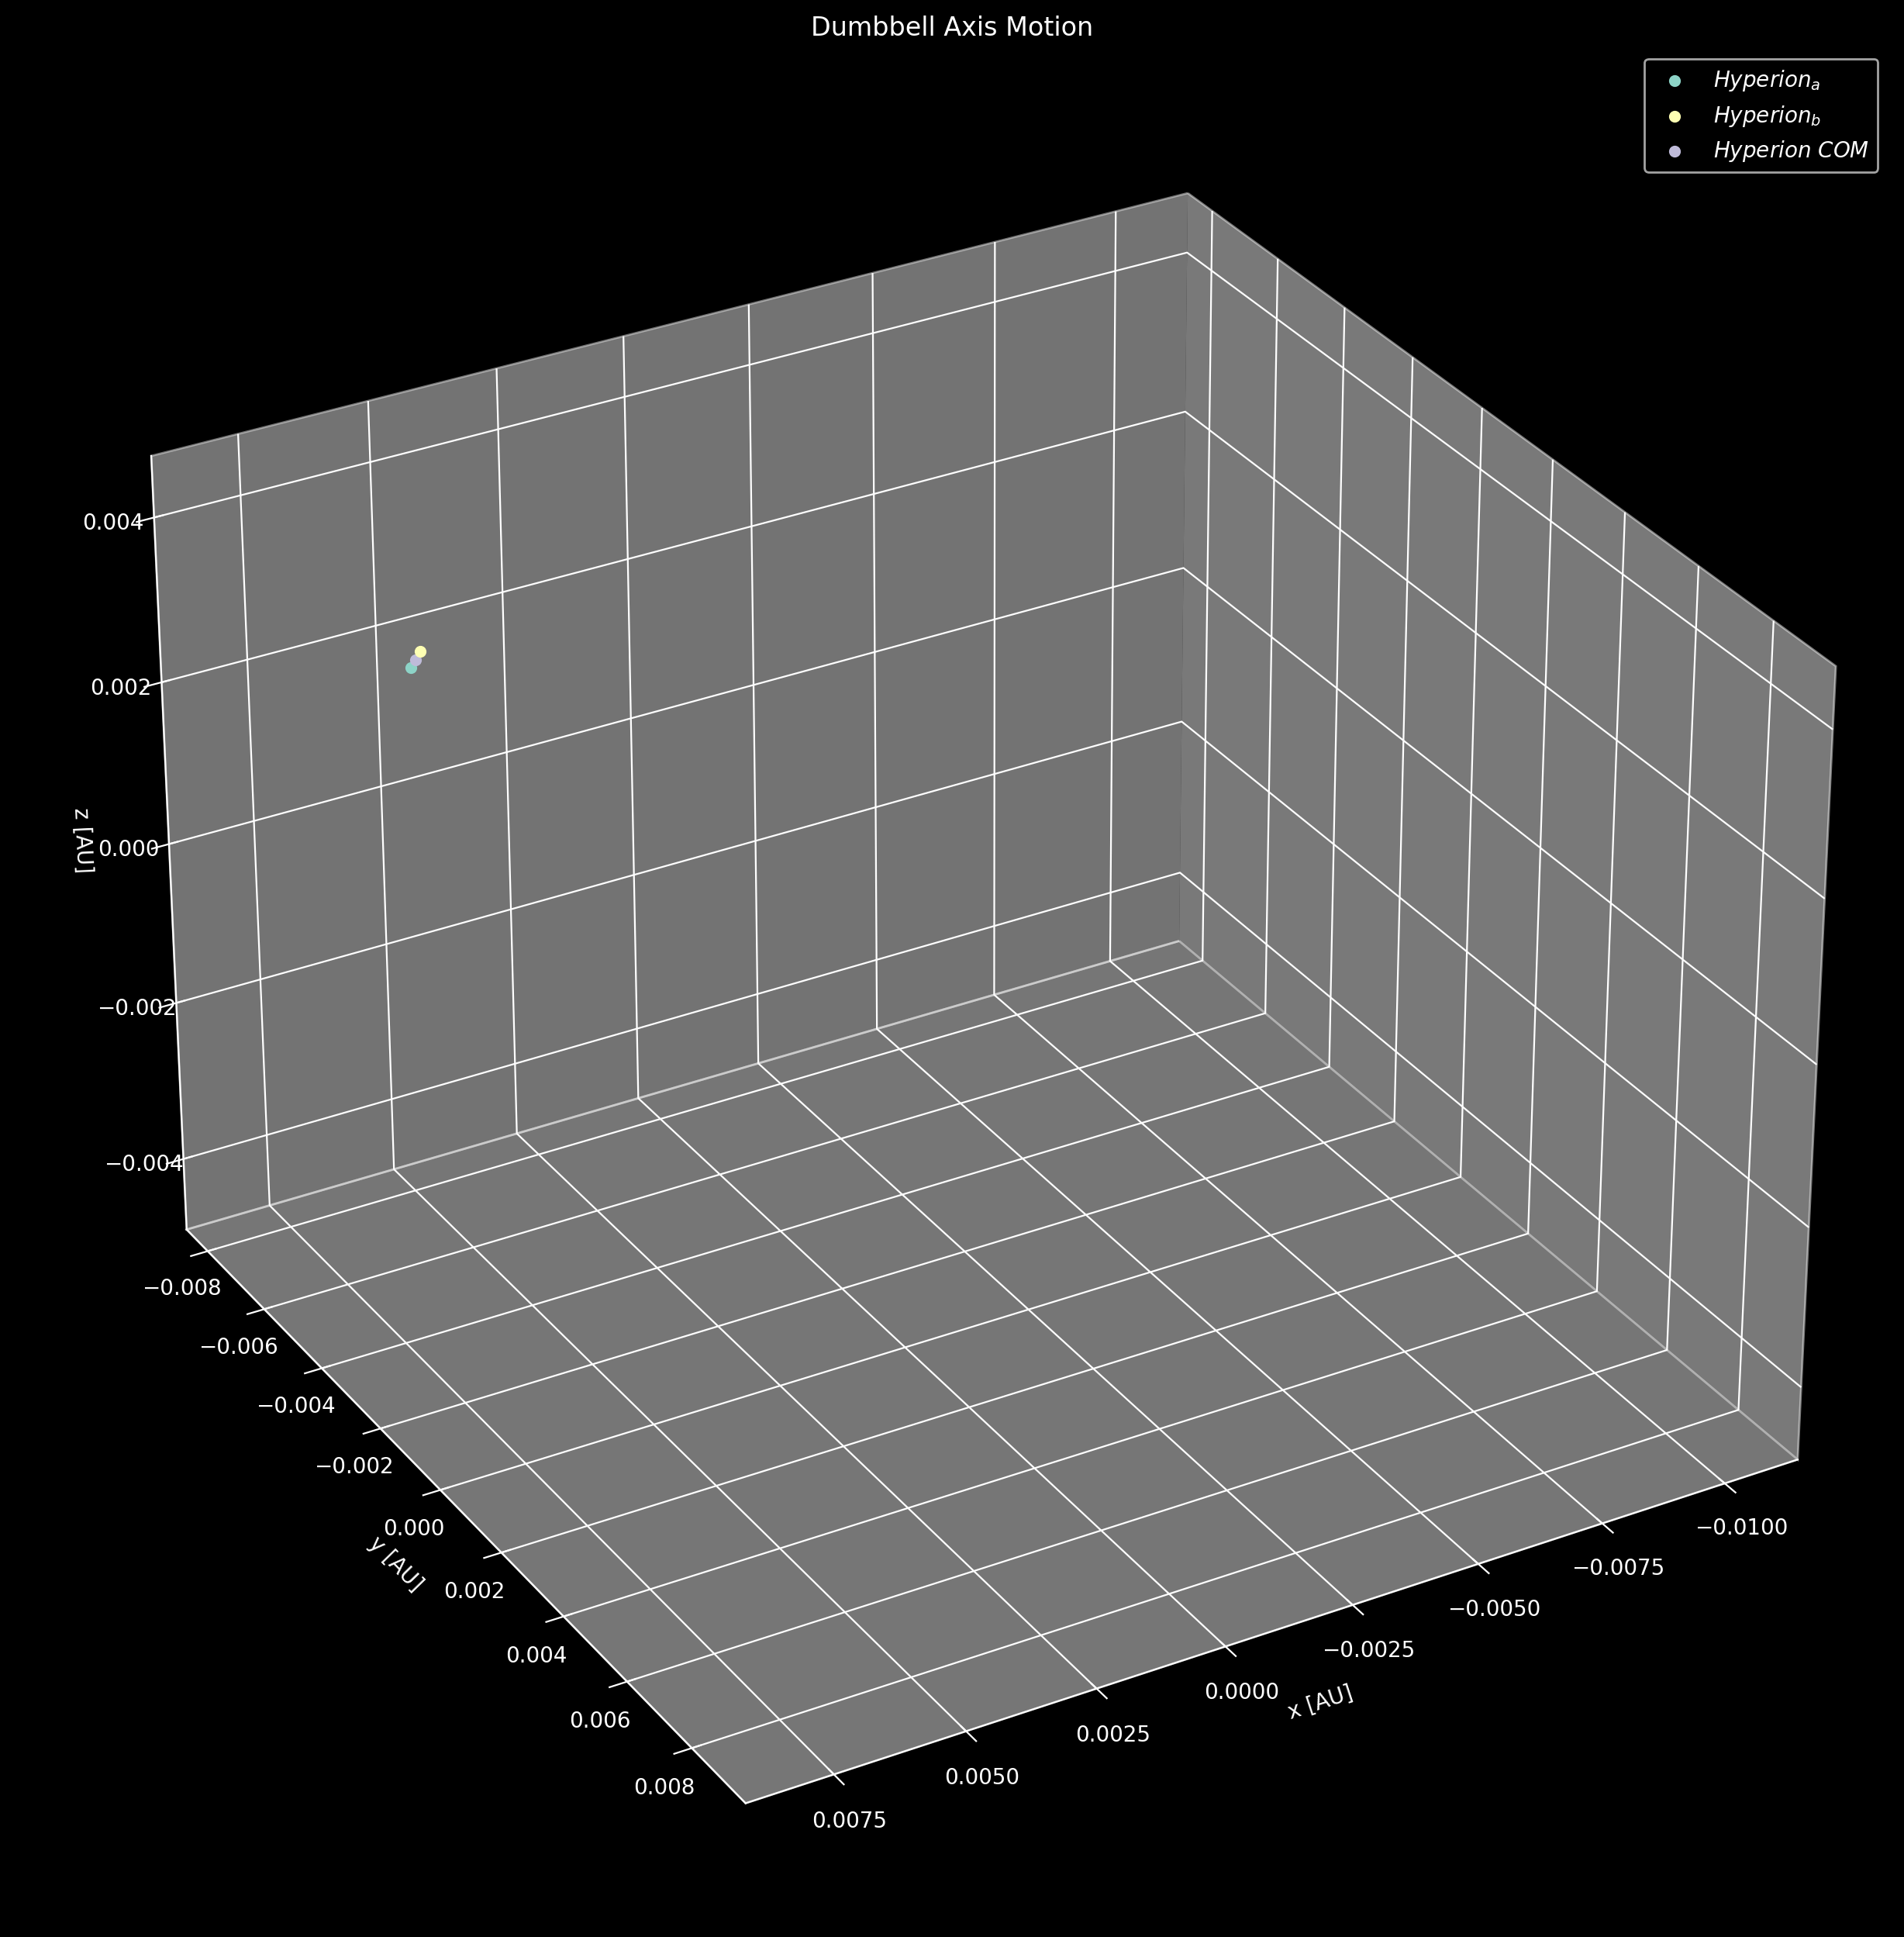

In [241]:
fig = plt.figure(figsize=global_fig_size, dpi=200)
ax = fig.add_subplot(111, projection='3d')
scatter0 = ax.scatter([],[],[], label=r'$Hyperion_a$')
scatter1 = ax.scatter([],[],[], label=r'$Hyperion_b$')
scatter2 = ax.scatter([],[],[], label=r'$Hyperion$ $COM$')
plot0, = ax.plot([],[],[])
plot1, = ax.plot([],[],[])
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ax.set_zlim(min_z, max_z)
ax.view_init(30, 60)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('Dumbbell Axis Motion')
plt.legend()
def animate(i):
    scatter0._offsets3d = np.hsplit(x2[:,i],3)
    scatter1._offsets3d = np.hsplit(x3[:,i],3)
    scatter2._offsets3d = np.hsplit(CM[:,i],3)
    plot0.set_data_3d((com[0,i],x2[0,i]),(com[1,i],x2[1,i]),(com[2,i],x2[2,i]))
    plot1.set_data_3d((com[0,i],x3[0,i]),(com[1,i],x3[1,i]),(com[2,i],x3[2,i]))
    return scatter0, scatter1, scatter2, plot0, plot1
ani = FuncAnimation(fig, animate, t.size, interval=50, blit=True)
ani.save('videos/P1b.avi')

In [242]:
xa0, xa1, xa2, xa3, va0, va1, va2, va3, ta = run_simulation(theta,    0.0, phi, dphi, fps, duration, k, G, alpha=0.25, vel_boost=1.0)
xb0, xb1, xb2, xb3, vb0, vb1, vb2, vb3, tb = run_simulation(theta, dtheta, phi,  0.0, fps, duration, k, G, alpha=0.25, vel_boost=1.0)
xc0, xc1, xc2, xc3, vc0, vc1, vc2, vc3, tc = run_simulation(theta,    0.0, phi, dphi, fps, duration, k, G, alpha=0.25, vel_boost=np.sqrt(2))
xd0, xd1, xd2, xd3, vd0, vd1, vd2, vd3, td = run_simulation(theta, dtheta, phi,  0.0, fps, duration, k, G, alpha=0.25, vel_boost=np.sqrt(2))

xe0, xe1, xe2, xe3, ve0, ve1, ve2, ve3, te = run_simulation(theta,    0.0, phi, dphi, fps, duration, k, G, alpha=0.50, vel_boost=1.0)
xf0, xf1, xf2, xf3, vf0, vf1, vf2, vf3, tf = run_simulation(theta, dtheta, phi,  0.0, fps, duration, k, G, alpha=0.50, vel_boost=1.0)
xg0, xg1, xg2, xg3, vg0, vg1, vg2, vg3, tg = run_simulation(theta,    0.0, phi, dphi, fps, duration, k, G, alpha=0.50, vel_boost=np.sqrt(2))
xh0, xh1, xh2, xh3, vh0, vh1, vh2, vh3, th = run_simulation(theta, dtheta, phi,  0.0, fps, duration, k, G, alpha=0.50, vel_boost=np.sqrt(2))

xi0, xi1, xi2, xi3, vi0, vi1, vi2, vi3, ti = run_simulation(theta,    0.0, phi, dphi, fps, duration, k, G, alpha=0.75, vel_boost=1.0)
xj0, xj1, xj2, xj3, vj0, vj1, vj2, vj3, tj = run_simulation(theta, dtheta, phi,  0.0, fps, duration, k, G, alpha=0.75, vel_boost=1.0)
xk0, xk1, xk2, xk3, vk0, vk1, vk2, vk3, tk = run_simulation(theta,    0.0, phi, dphi, fps, duration, k, G, alpha=0.75, vel_boost=np.sqrt(2))
xl0, xl1, xl2, xl3, vl0, vl1, vl2, vl3, tl = run_simulation(theta, dtheta, phi,  0.0, fps, duration, k, G, alpha=0.75, vel_boost=np.sqrt(2))

In [243]:
vec_a = xa3 - xa2; _, phi_a, theta_a = cart2sph(*vec_a)
vec_b = xb3 - xb2; _, phi_b, theta_b = cart2sph(*vec_b)
vec_c = xc3 - xc2; _, phi_c, theta_c = cart2sph(*vec_c)
vec_d = xd3 - xd2; _, phi_d, theta_d = cart2sph(*vec_d)
vec_e = xe3 - xe2; _, phi_e, theta_e = cart2sph(*vec_e)
vec_f = xf3 - xf2; _, phi_f, theta_f = cart2sph(*vec_f)
vec_g = xg3 - xg2; _, phi_g, theta_g = cart2sph(*vec_g)
vec_h = xh3 - xh2; _, phi_h, theta_h = cart2sph(*vec_h)
vec_i = xi3 - xi2; _, phi_i, theta_i = cart2sph(*vec_i)
vec_j = xj3 - xj2; _, phi_j, theta_j = cart2sph(*vec_j)
vec_k = xk3 - xk2; _, phi_k, theta_k = cart2sph(*vec_k)
vec_l = xl3 - xl2; _, phi_l, theta_l = cart2sph(*vec_l)

In [244]:
fig, axs = plt.subplots(3,4, figsize=(4*global_fig_size[0],3*global_fig_size[1]), sharex=True, sharey=True, constrained_layout=True, dpi=200)

axs[0,0].set_title(r'$\dot{\theta}_0=0$, $\dot{\phi}_0=\pi$, $\alpha=1/4$, $||v||=v_0$')
axs[0,0].plot(ta, theta_a, label=r'$\theta$')
axs[0,0].plot(ta,   phi_a, label=r'$\phi$')
axs[0,1].set_title(r'$\dot{\theta}_0=\pi$, $\dot{\phi}_0=0$, $\alpha=1/4$, $||v||=v_0$')
axs[0,1].plot(tb, theta_b, label=r'$\theta$')
axs[0,1].plot(tb,   phi_b, label=r'$\phi$')
axs[0,2].set_title(r'$\dot{\theta}_0=0$, $\dot{\phi}_0=\pi$, $\alpha=1/4$, $||v||=\sqrt{2}v_0$')
axs[0,2].plot(tc, theta_c, label=r'$\theta$')
axs[0,2].plot(tc,   phi_c, label=r'$\phi$')
axs[0,3].set_title(r'$\dot{\theta}_0=\pi$, $\dot{\phi}_0=0$, $\alpha=1/4$, $||v||=\sqrt{2}v_0$')
axs[0,3].plot(td, theta_d, label=r'$\theta$')
axs[0,3].plot(td,   phi_d, label=r'$\phi$')
##
axs[1,0].set_title(r'$\dot{\theta}_0=0$, $\dot{\phi}_0=\pi$, $\alpha=1/2$, $||v||=v_0$')
axs[1,0].plot(te, theta_e, label=r'$\theta$')
axs[1,0].plot(te,   phi_e, label=r'$\phi$')
axs[1,1].set_title(r'$\dot{\theta}_0=\pi$, $\dot{\phi}_0=0$, $\alpha=1/2$, $||v||=v_0$')
axs[1,1].plot(tf, theta_f, label=r'$\theta$')
axs[1,1].plot(tf,   phi_f, label=r'$\phi$')
axs[1,2].set_title(r'$\dot{\theta}_0=0$, $\dot{\phi}_0=\pi$, $\alpha=1/2$, $||v||=\sqrt{2}v_0$')
axs[1,2].plot(tg, theta_g, label=r'$\theta$')
axs[1,2].plot(tg,   phi_g, label=r'$\phi$')
axs[1,3].set_title(r'$\dot{\theta}_0=\pi$, $\dot{\phi}_0=0$, $\alpha=1/2$, $||v||=\sqrt{2}v_0$')
axs[1,3].plot(th, theta_h, label=r'$\theta$')
axs[1,3].plot(th,   phi_h, label=r'$\phi$')
##
axs[2,0].set_title(r'$\dot{\theta}_0=0$, $\dot{\phi}_0=\pi$, $\alpha=3/4$, $||v||=v_0$')
axs[2,0].plot(ti, theta_i, label=r'$\theta$')
axs[2,0].plot(ti,   phi_i, label=r'$\phi$')
axs[2,1].set_title(r'$\dot{\theta}_0=\pi$, $\dot{\phi}_0=0$, $\alpha=3/4$, $||v||=v_0$')
axs[2,1].plot(tj, theta_j, label=r'$\theta$')
axs[2,1].plot(tj,   phi_j, label=r'$\phi$')
axs[2,2].set_title(r'$\dot{\theta}_0=0$, $\dot{\phi}_0=\pi$, $\alpha=3/4$, $||v||=\sqrt{2}v_0$')
axs[2,2].plot(tk, theta_k, label=r'$\theta$')
axs[2,2].plot(tk,   phi_k, label=r'$\phi$')
axs[2,3].set_title(r'$\dot{\theta}_0=\pi$, $\dot{\phi}_0=0$, $\alpha=3/4$, $||v||=\sqrt{2}v_0$')
axs[2,3].plot(tl, theta_l, label=r'$\theta$')
axs[2,3].plot(tl,   phi_l, label=r'$\phi$')

for _ in axs:
    for ax in _:
        ax.set_xlabel('t [d]')
        ax.set_ylabel('[rad]')
        ax.grid()
        ax.legend()

plt.savefig('pictures/P1c.png')

## Plots

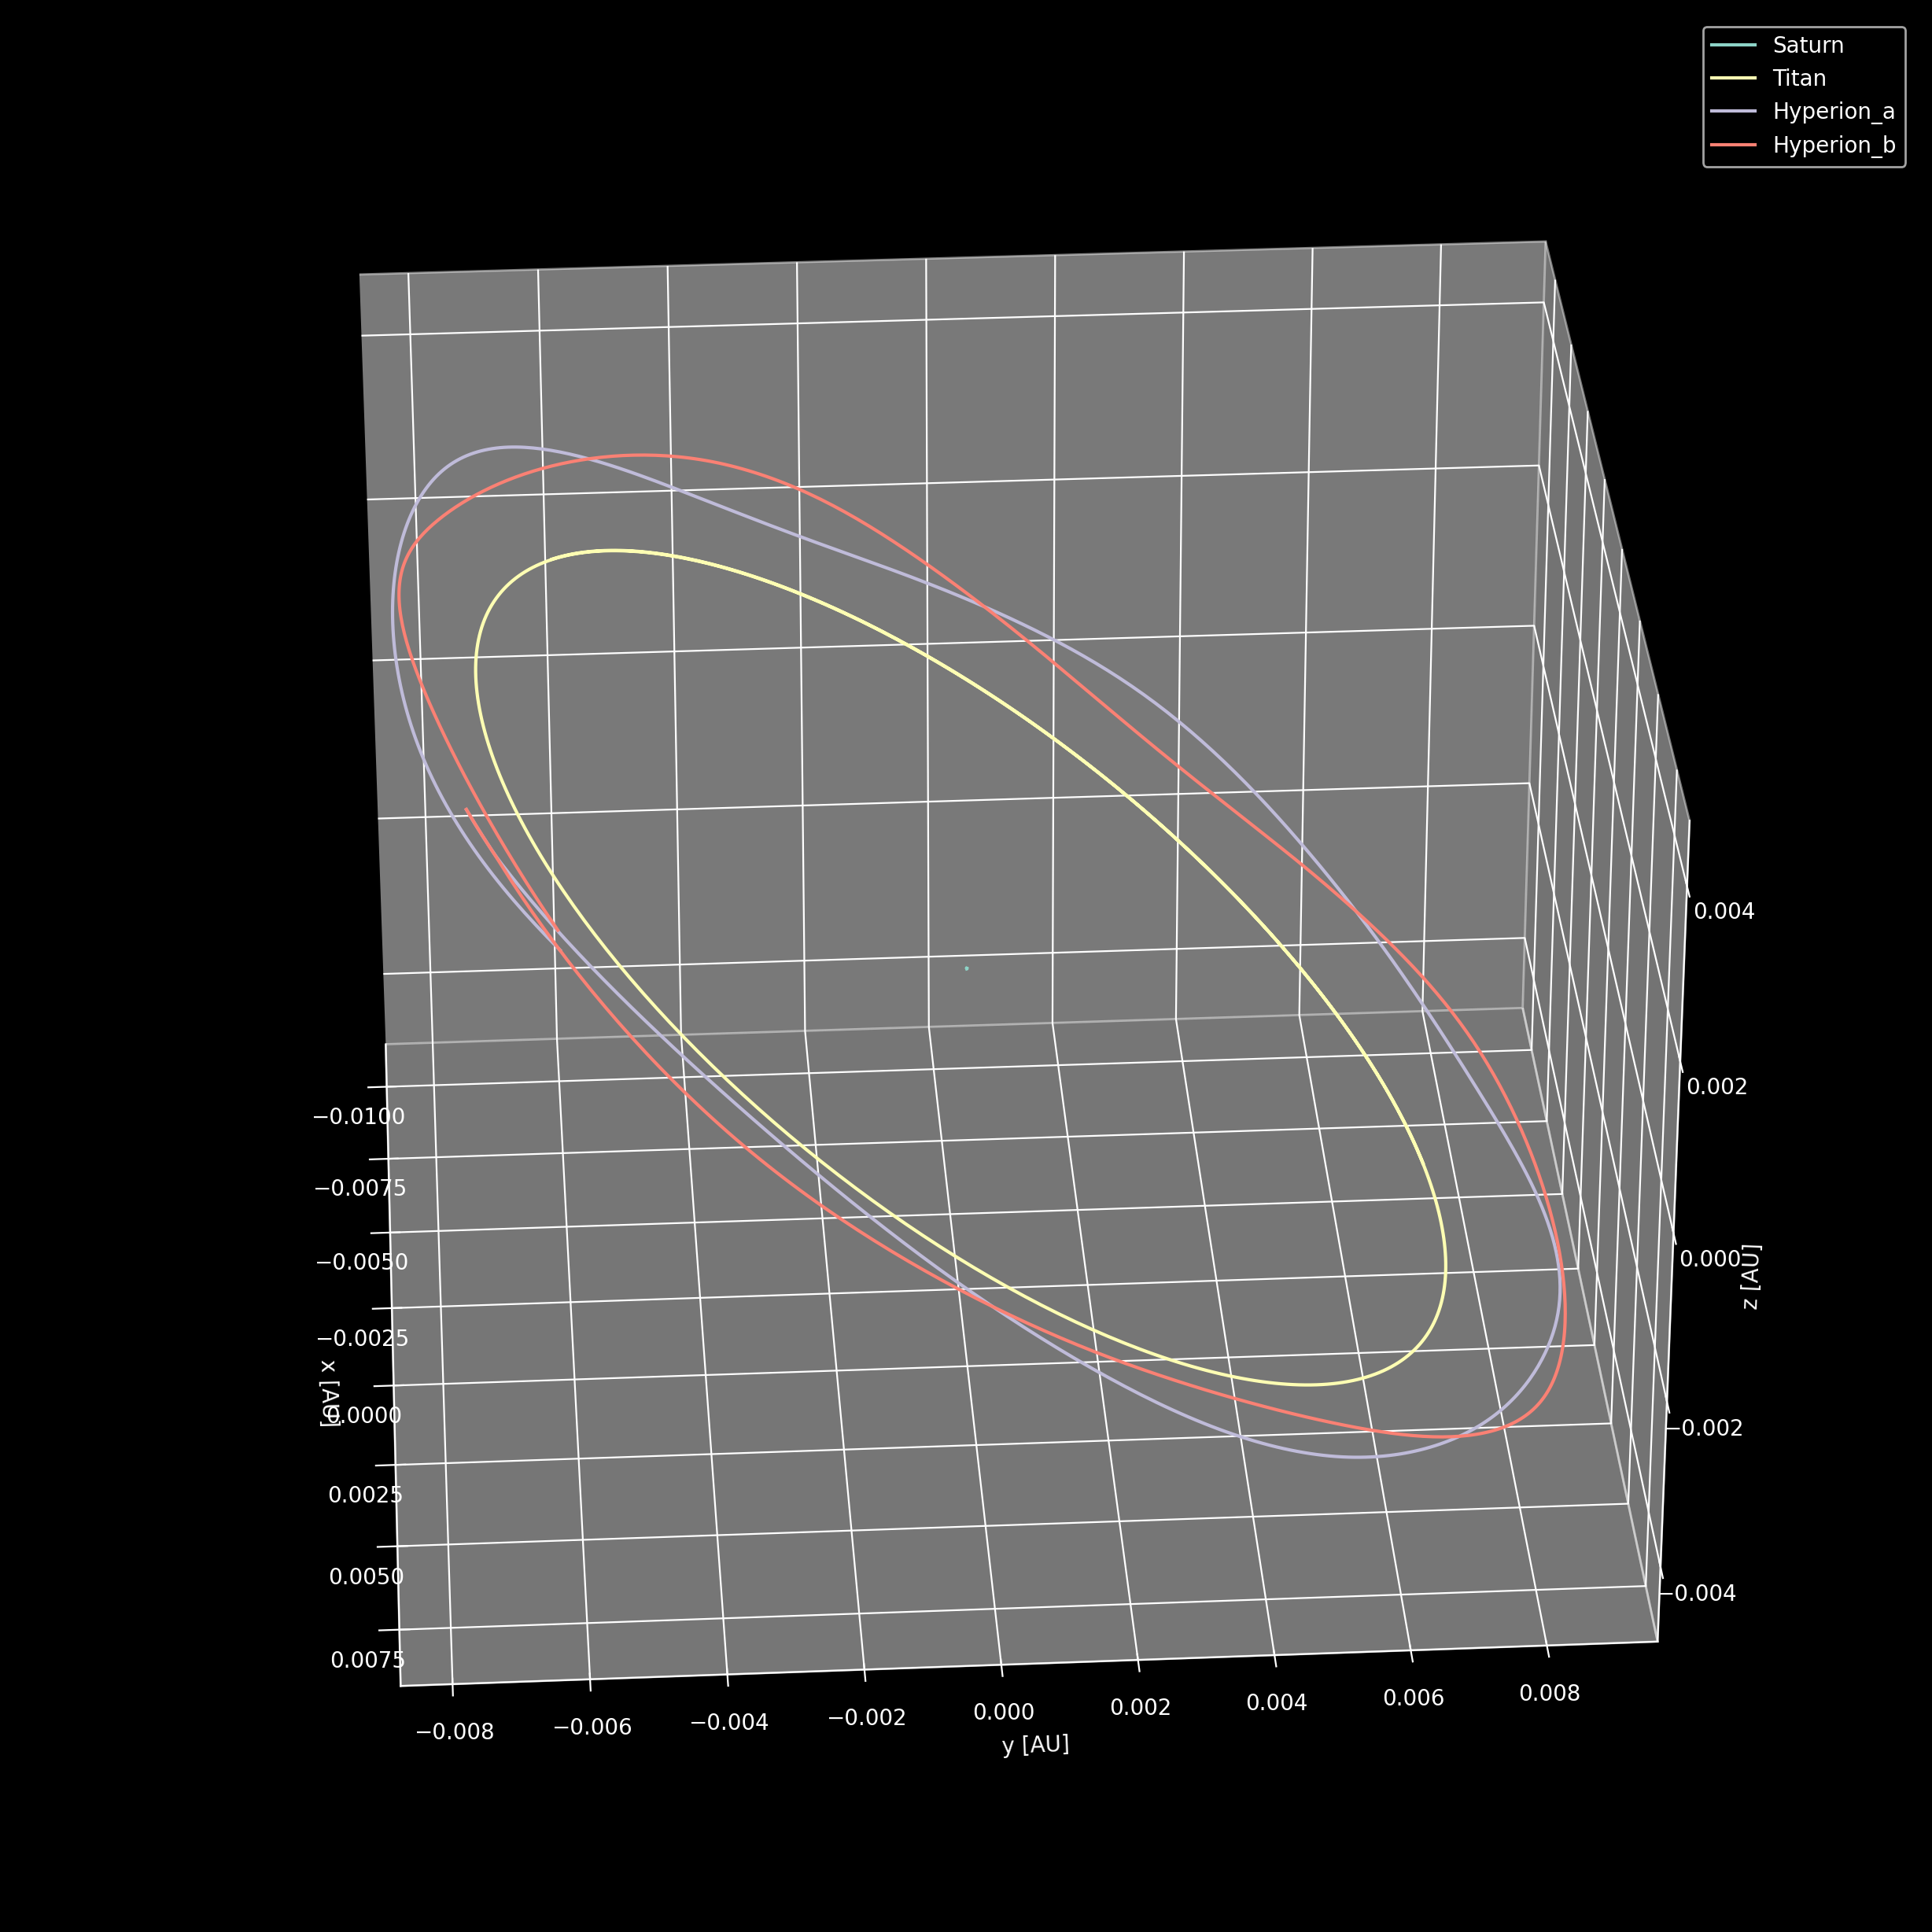

In [247]:
N = 100
fig = plt.figure(figsize=global_fig_size, dpi=200)
ax = fig.add_subplot(111, projection='3d')
plot0, = ax.plot([],[],[], label=r'Saturn')
plot1, = ax.plot([],[],[], label=r'Titan')
plot2, = ax.plot([],[],[], label=r'Hyperion_a')
plot3, = ax.plot([],[],[], label=r'Hyperion_b')
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ax.set_zlim(min_z, max_z)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
plt.legend()
def animate(i):
    plot0.set_data_3d(x0[0,:], x0[1,:], x0[2,:])
    plot1.set_data_3d(x1[0,:], x1[1,:], x1[2,:])
    plot2.set_data_3d(x2[0,:], x2[1,:], x2[2,:])
    plot3.set_data_3d(x3[0,:], x3[1,:], x3[2,:])
    ax.view_init(30, 360*i/N)
    return plot0, plot1, plot2, plot3   
ani = FuncAnimation(fig, animate, N, interval=100, blit=True)
ani.save('videos/orbit_360.avi')

## Problem 2

Now modify the starter code (or create your own program) to study the “butterfly effect”, i.e., follow the evolution from two slightly different initial conditions for the dumbbell axis. Track both the angular orientation difference and angular velocity difference for the same circular and elliptic orbits as in (1), including the real Hyperion orbit. Use the results to further substantiate the conclusions you reached in (1), and calculate the Lyapunov exponents for each case. 

__[Note 2]__ The recommended way to extract Lyapunov exponents is to pick the local maxima of the time evolution series of the angle and angular velocity differences, and then do a linear, least-squares fit on a semi-log scale to (some of) those maxima. You will need to pick the range of data points that gives the most reasonable fits (rather than fit to all the maxima). Thus, it will be best to save those data so that you can repeat the fits for different range choices. You can either write the data to text files, and use separate Python programs (or even different utilities, such as gnuplot) to do the fitting. Or scipy.optimize.curve_fit.

__[Note 4]__ Make sure to confirm that the Lyapunov exponents you obtain are reliable and not artifacts of numerical error accumulation. You can get an idea of numerical errors by improving your calculation and checking how the results differ.

In [260]:
xa0, xa1, xa2, xa3, va0, va1, va2, va3, ta = run_simulation(theta, 0.9999*dtheta, phi, 0.9999*dphi, fps, 5*duration, k, G, alpha=0.5, vel_boost=1.0)
xb0, xb1, xb2, xb3, vb0, vb1, vb2, vb3, tb = run_simulation(theta,     dtheta, phi, dphi, fps, 5*duration, k, G, alpha=0.5, vel_boost=1.0)

In [261]:
vec_x_a = xa3 - xa2; vec_v_a = va3 - va2
vec_x_b = xb3 - xb2; vec_v_b = vb3 - vb2

_, phi_a, theta_a = cart2sph(*vec_x_a); _, dphi_a, dtheta_a = cart2sph(*vec_v_a)
_, phi_b, theta_b = cart2sph(*vec_x_b); _, dphi_b, dtheta_b = cart2sph(*vec_v_b)

delta_phi = phi_b - phi_a; delta_dphi = dphi_b - dphi_a
delta_theta = theta_b - theta_a; delta_dtheta = dtheta_b - dtheta_a

peak_delta_theta = find_peaks(delta_theta); peak_delta_dtheta = find_peaks(delta_dtheta)
peak_delta_phi = find_peaks(delta_phi); peak_delta_dphi = find_peaks(delta_dphi)

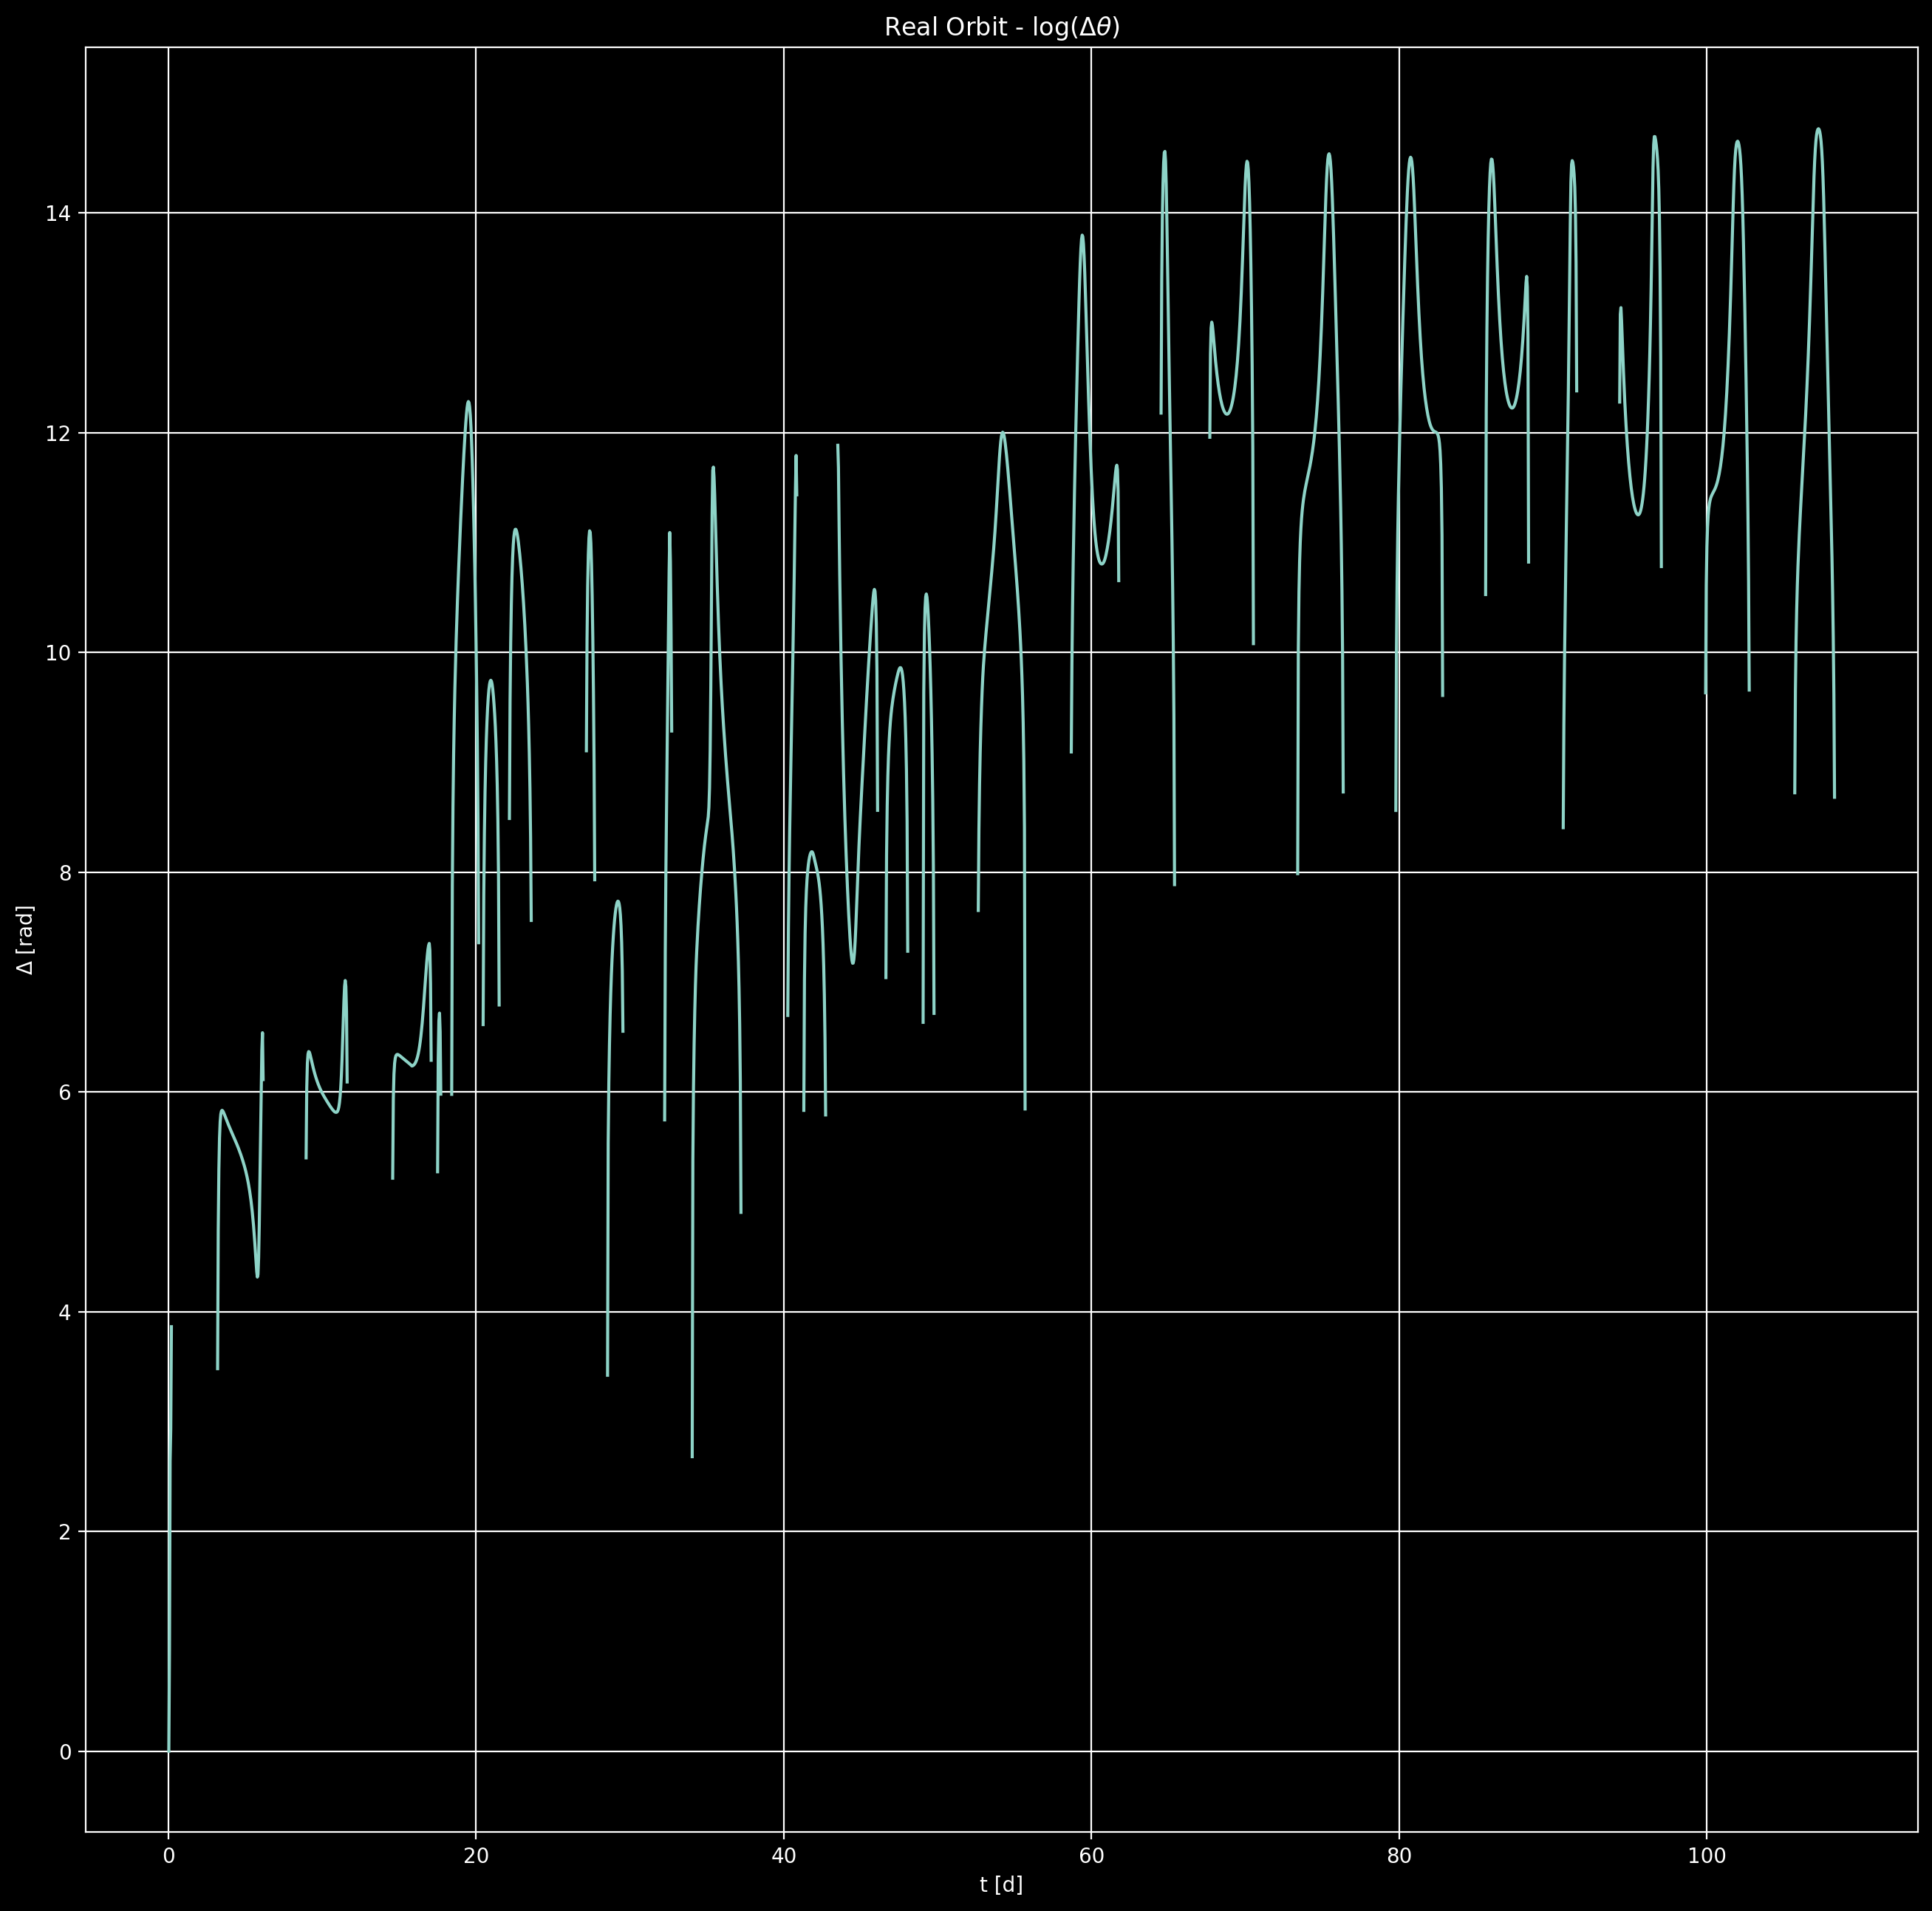

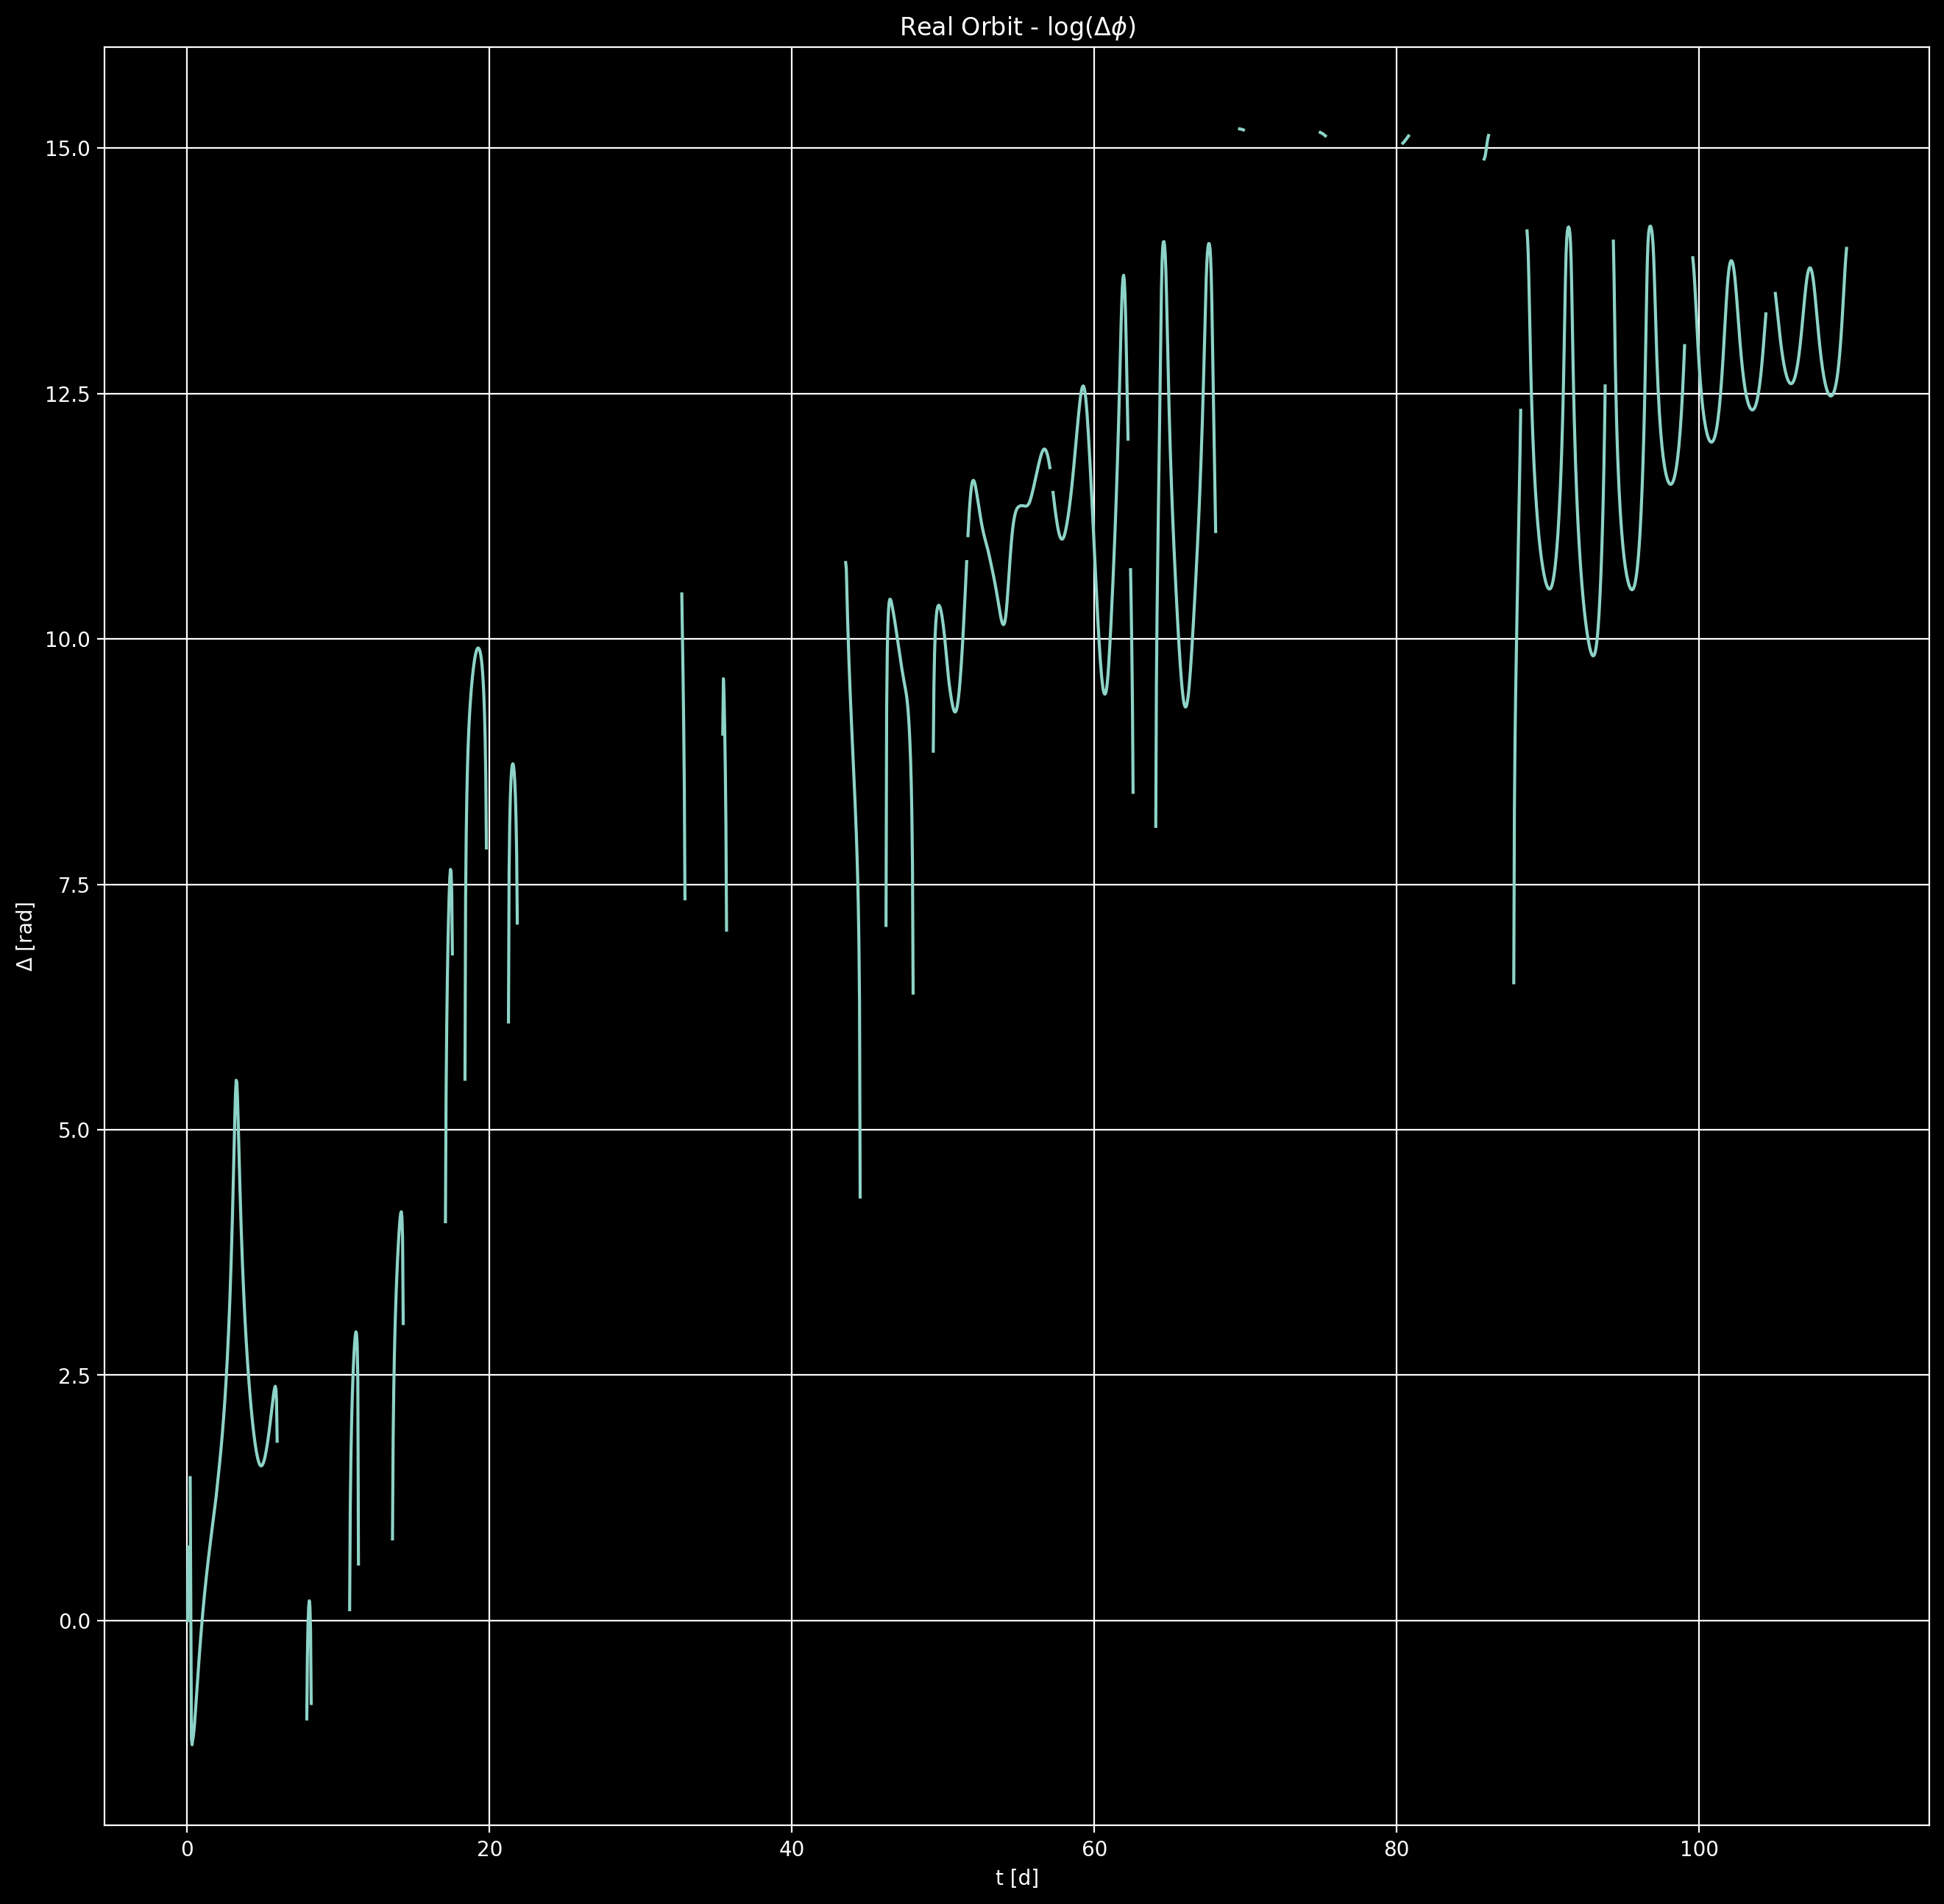

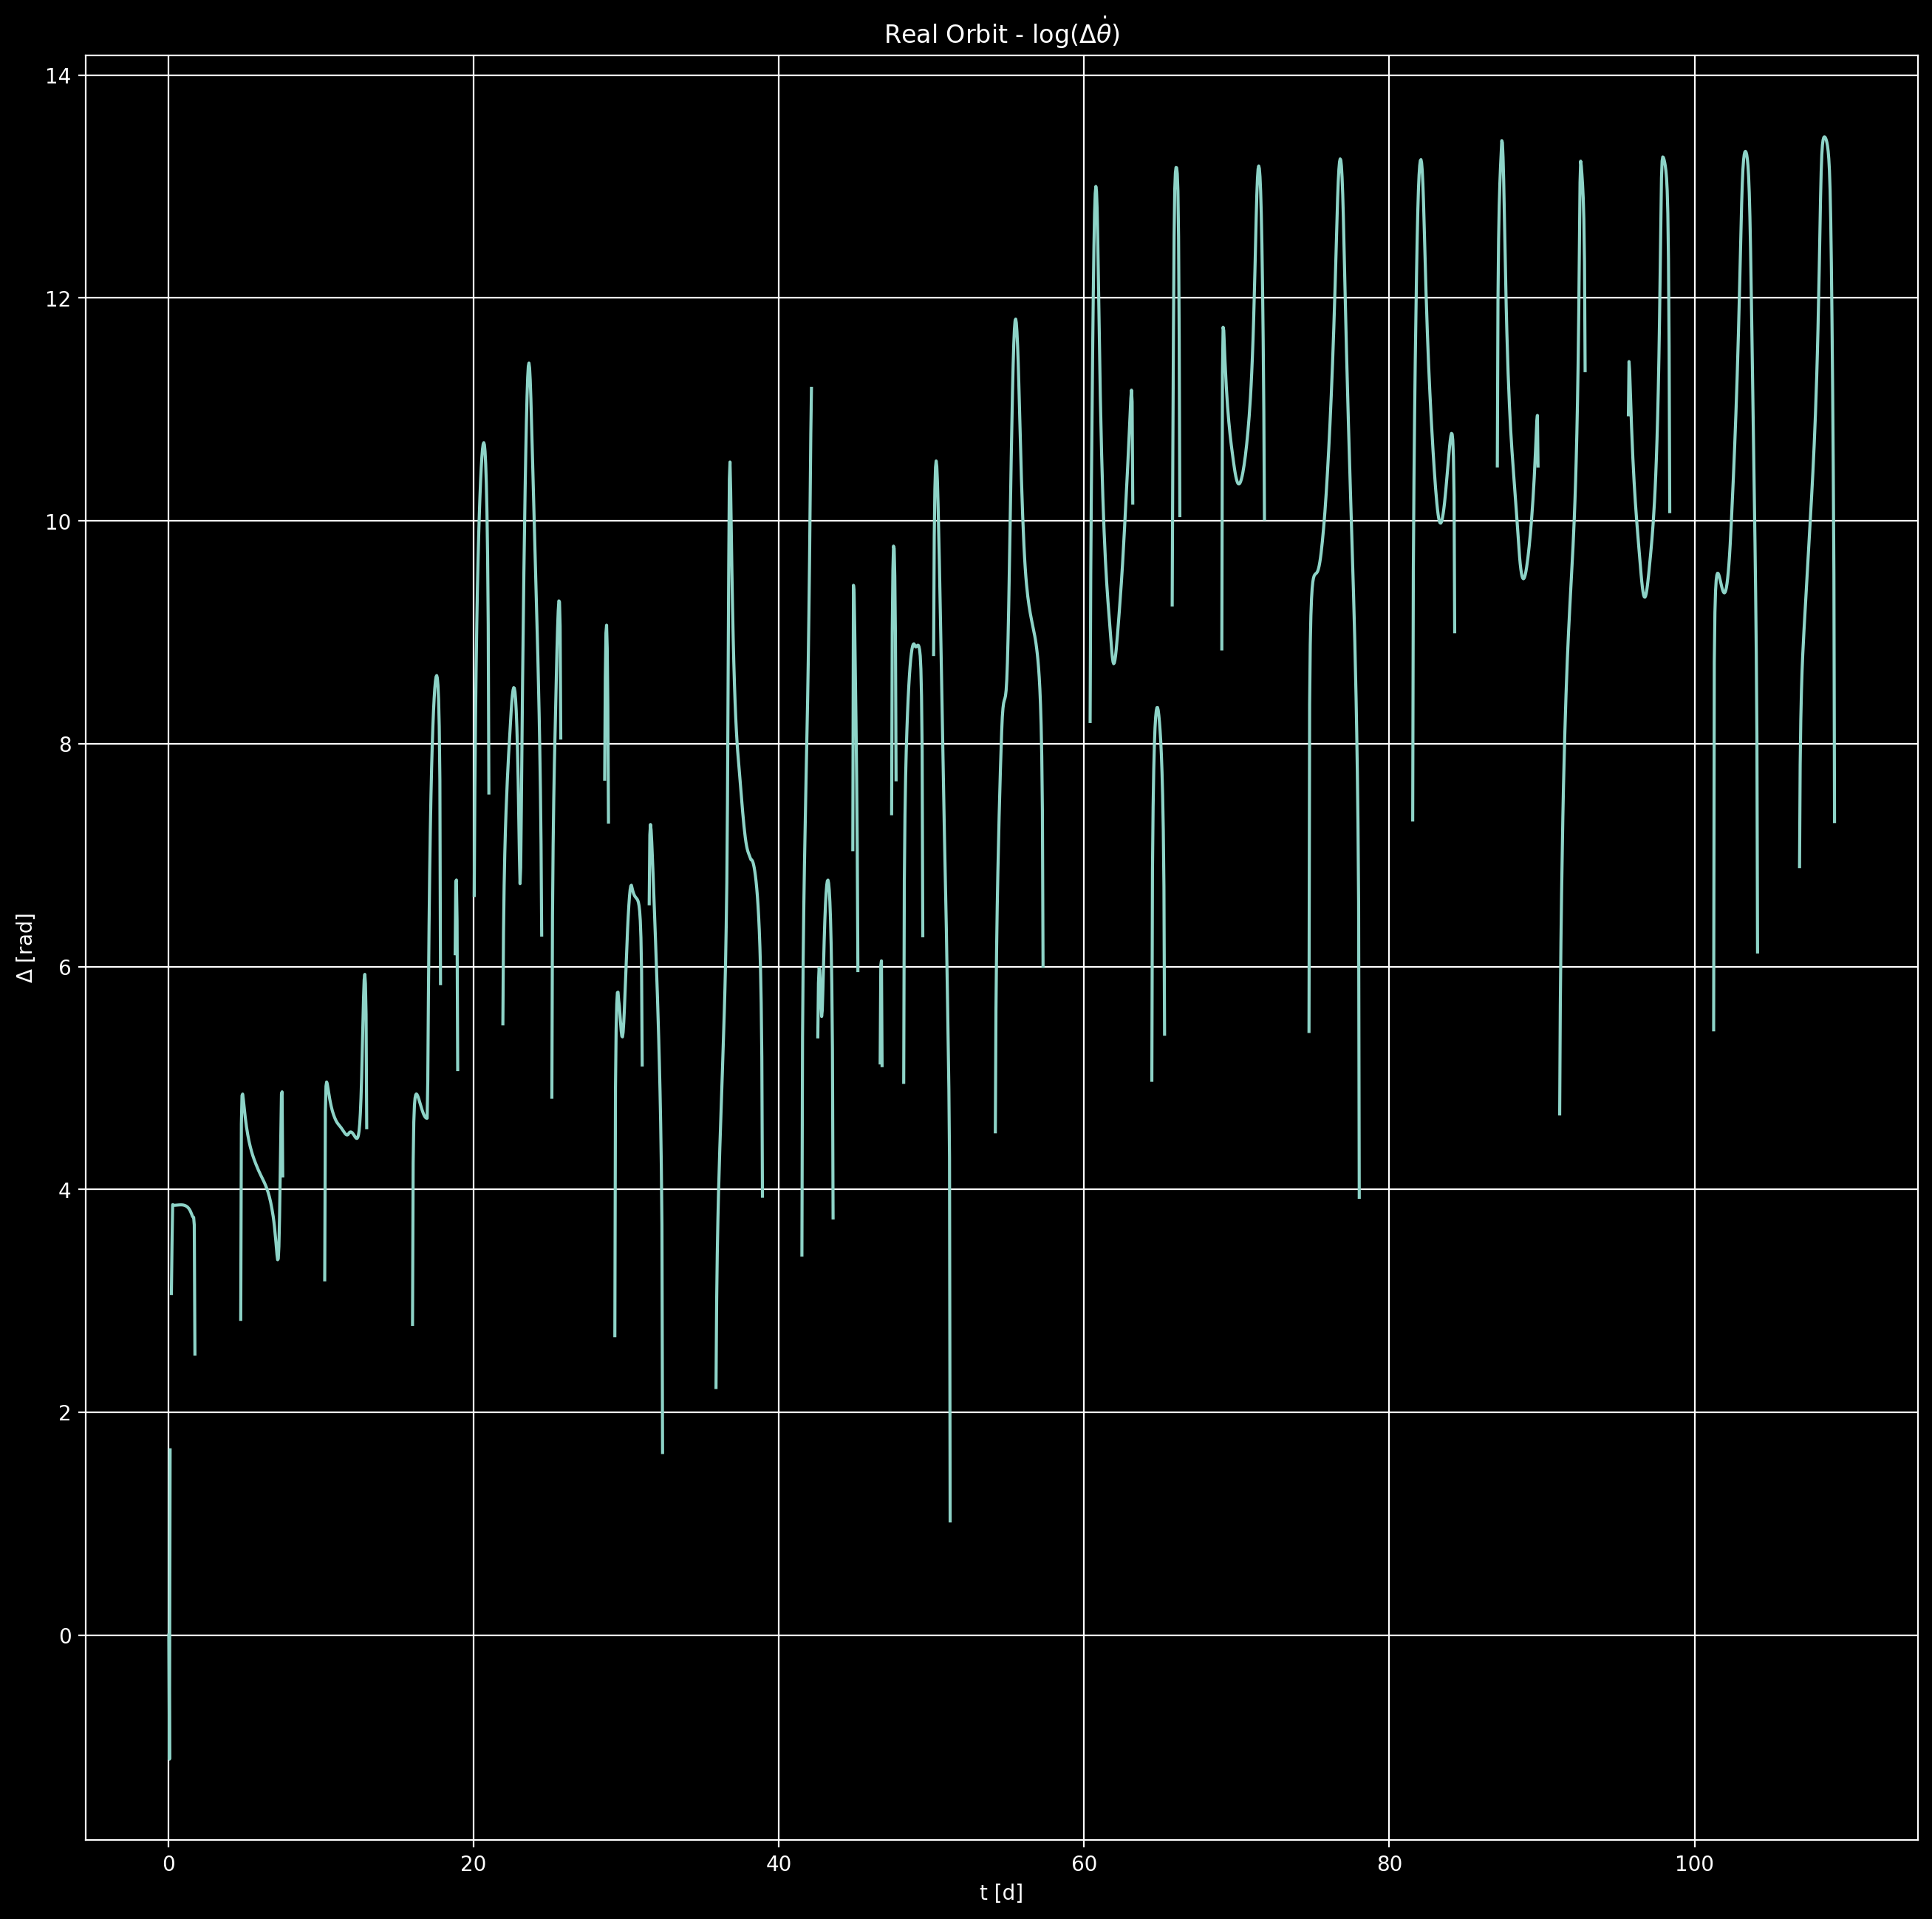

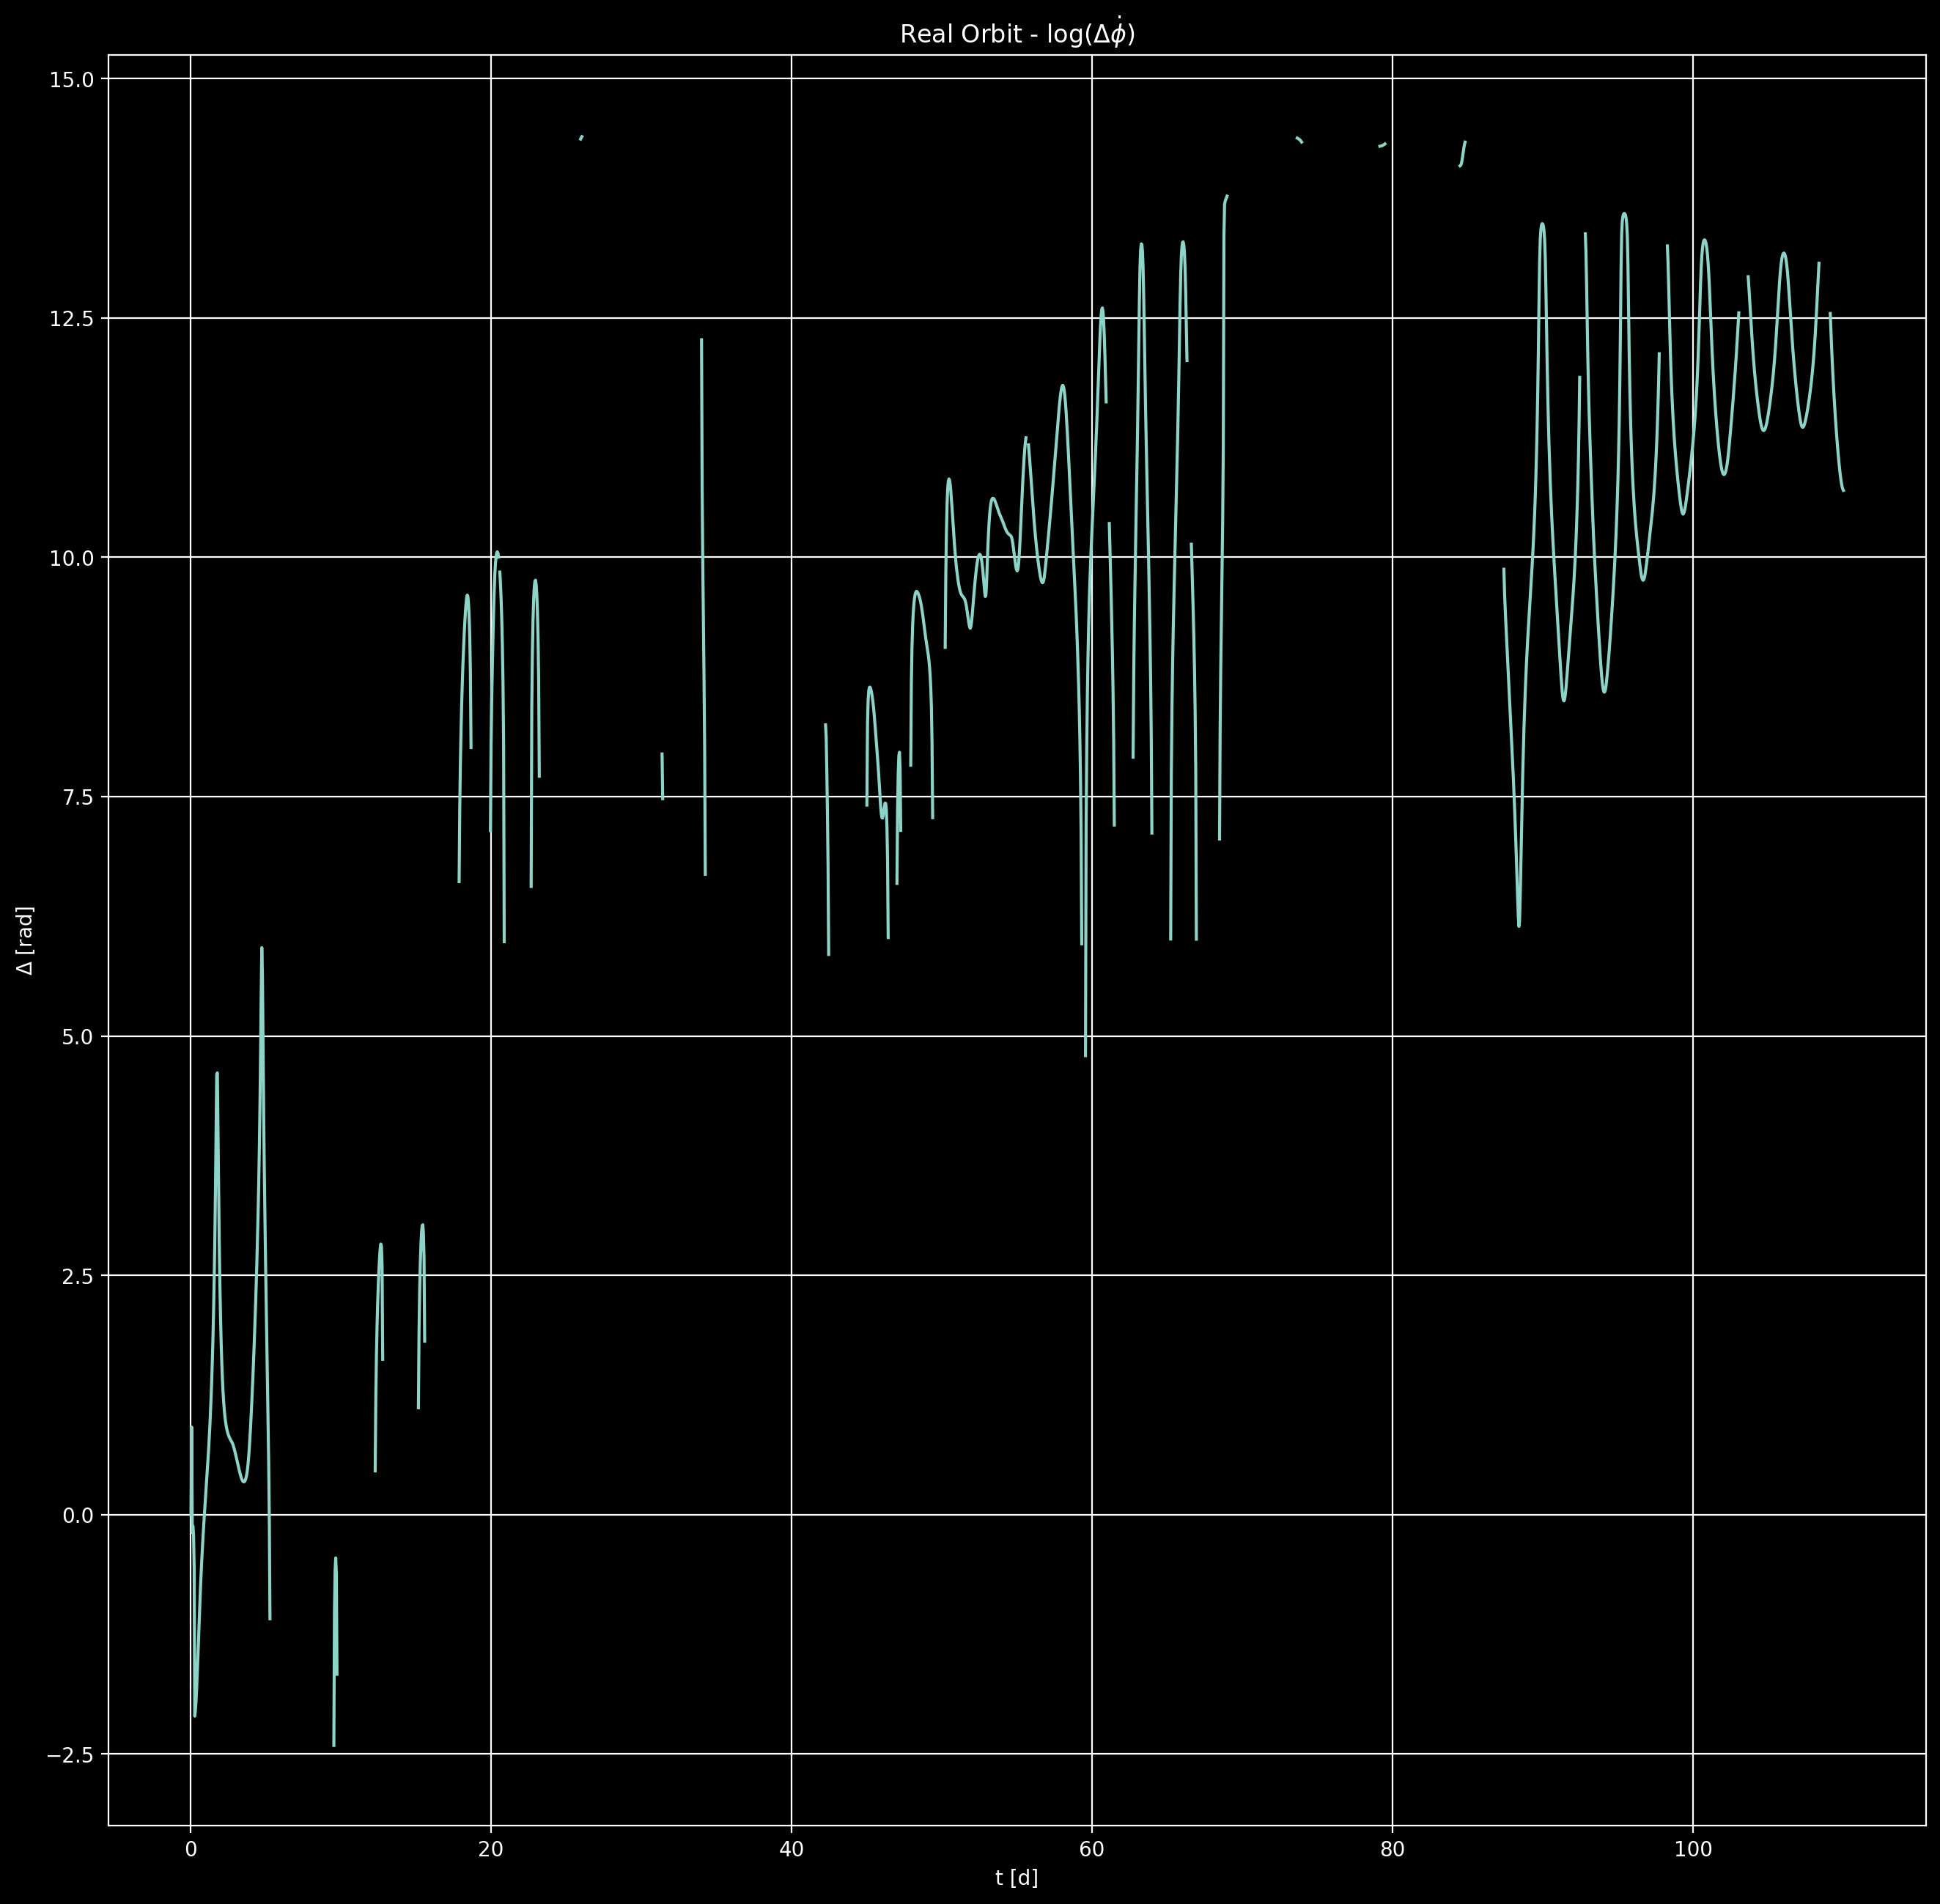

In [262]:
fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\theta)}$')
ax.plot(ta, np.log(delta_theta/delta_theta[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2a_1.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\phi)}$')
ax.plot(ta, np.log(delta_phi/delta_phi[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2a_2.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\dot\theta)}$')
ax.plot(ta, np.log(delta_dtheta/delta_dtheta[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2a_3.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\dot\phi)}$')
ax.plot(ta, np.log(delta_dphi/delta_dphi[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2a_4.png')

In [267]:
fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\theta)}$')
ax.plot(ta, np.take_along_axis(delta_theta,peak_delta_theta,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2b_1.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\phi)}$')
ax.plot(ta, np.take_along_axis(delta_phi,peak_delta_phi,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2b_2.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\dot\theta)}$')
ax.plot(ta, np.take_along_axis(delta_dtheta,peak_delta_dtheta,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2b_3.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Real Orbit - $\log{(\Delta\dot\phi)}$')
ax.plot(ta, np.take_along_axis(delta_dphi,peak_delta_dphi,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2b_4.png')

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
xc0, xc1, xc2, xc3, vc0, vc1, vc2, vc3, tc = run_simulation(theta, 0.9999*dtheta, phi, 0.9999*dphi, fps, 5*duration, k, G, alpha=0.5, vel_boost=np.sqrt(2.0))
xd0, xd1, xd2, xd3, vd0, vd1, vd2, vd3, td = run_simulation(theta,     dtheta, phi, dphi, fps, 5*duration, k, G, alpha=0.5, vel_boost=np.sqrt(2.0))

vec_x_c = xc3 - xc2; vec_v_c = vc3 - vc2
vec_x_d = xd3 - xd2; vec_v_d = vd3 - vd2

_, phi_c, theta_c = cart2sph(*vec_x_c); _, dphi_c, dtheta_c = cart2sph(*vec_v_c)
_, phi_d, theta_d = cart2sph(*vec_x_d); _, dphi_d, dtheta_d = cart2sph(*vec_v_d)

delta_phi = phi_d - phi_c; delta_dphi = dphi_d - dphi_c
delta_theta = theta_d - theta_c; delta_dtheta = dtheta_d - dtheta_c

peak_delta_theta = find_peaks(delta_theta); peak_delta_dtheta = find_peaks(delta_dtheta)
peak_delta_phi = find_peaks(delta_phi); peak_delta_dphi = find_peaks(delta_dphi)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\theta)}$')
ax.plot(ta, np.log(delta_theta/delta_theta[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2c_1.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\phi)}$')
ax.plot(ta, np.log(delta_phi/delta_phi[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2c_2.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\dot\theta)}$')
ax.plot(ta, np.log(delta_dtheta/delta_dtheta[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2c_3.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\dot\phi)}$')
ax.plot(ta, np.log(delta_dphi/delta_dphi[1]))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2_4.png')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\theta)}$')
ax.plot(ta, np.take_along_axis(delta_theta,peak_delta_theta,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2d_1.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\phi)}$')
ax.plot(ta, np.take_along_axis(delta_phi,peak_delta_phi,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2d_2.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\dot\theta)}$')
ax.plot(ta, np.take_along_axis(delta_dtheta,peak_delta_dtheta,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2d_3.png')

fig, ax = plt.subplots(1,1, figsize=global_fig_size, dpi=200)
ax.set_title(r'Elliptical Orbit - $\log{(\Delta\dot\phi)}$')
ax.plot(ta, np.take_along_axis(delta_dphi,peak_delta_dphi,0))
ax.set_xlabel('t [d]')
ax.set_ylabel(r'$\Delta$ [rad]')
ax.grid()
plt.savefig('pictures/P2c_4.png')